<Response [200]>

In [14]:
import pandas as pd
import time
import datetime
import csv
import seaborn as sns
import matplotlib.pyplot as plt

## Archiving Reddit data from API

We used the Pushshift API for gathering the data from Reddit. The Pushshift API allows
us to search posts from a specific time. This API finds all the queries that we type into the parameter. We are getting Data from English Primier League Subreddit.

In [37]:
def getData(team, after, before):
    url = 'https://api.pushshift.io/reddit/search/submission/?q='+str(team)+'&subreddit=PremierLeague&after='+str(after)+'&before='+str(before)+'&size=100'
    epl = requests.get(url)
    try:
        push = epl.json(encoding="utf-8")
        return push['data']
    except:
        return []

In [38]:
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

In [39]:
text = []
team = ['Arsenal', 'Aston Villa', 'Burnley', 'Chelsea', 'Crystal Palace',
'Everton', 'Hull City', 'Leicester City', 'Liverpool',
'Manchester City', 'Manchester United', 'Newcastle', 'QPR', 'Southampton', 'Stoke City',
'Sunderland', 'Swansea', 'Tottenham', 'WBA', 'West Ham']

# Gathering all the text datas and train them by Word2Vec

for t in team:
    after = 1376665200 # 2013-2014
    before = 1595862000 # End of the 2019-2020 seasons
    data = getData(t, after, before)
    while len(data) > 0:
        for submission in data:
            if 'selftext' in submission:
                text.append(submission['selftext'])
        after = data[-1]['created_utc']
        data = getData(t, after, before)
lists = []
for i in range(len(text)):
    lists.append(simple_preprocess(text[i]))
model = Word2Vec(lists, vector_size=100, window=5, min_count=5, workers=4, sg = 0)

Arsenal
1376665200 1595862000
1399731414 1595862000
1416669281 1595862000
1445706462 1595862000
1470322195 1595862000
1484421286 1595862000
1494179557 1595862000
1502535436 1595862000
1506370509 1595862000
1511988631 1595862000
1515348537 1595862000
1519380772 1595862000
1523605151 1595862000
1532397057 1595862000
1536409063 1595862000
1546107130 1595862000
1555712461 1595862000
1564502633 1595862000
1569069624 1595862000
1575144969 1595862000
1580660260 1595862000
1589274692 1595862000
1592963092 1595862000
1595606782 1595862000
Aston Villa
1376665200 1595862000
Burnley
1376665200 1595862000
1505484701 1595862000
1533305252 1595862000
1565386090 1595862000
Chelsea
1376665200 1595862000
1404233874 1595862000
1417290792 1595862000
1442070264 1595862000
1456942824 1595862000
1483122375 1595862000
1493372773 1595862000
1502559154 1595862000
1508362375 1595862000
1512803711 1595862000
1516903190 1595862000
1521120272 1595862000
1531915654 1595862000
1536837856 1595862000
1546186150 1595862

In [40]:
# Good and Bad word lists
good = ['good', 'positive', 'best', 'amazing', 'win', 
        'nice', 'love', 'fun', 'favorite', 
        'cool', 'impressive', 'great']

bad = ['bad', 'awful', 'negative', 'lose', 'terrible',
      'worst', 'boring', 'hate', 'unimpressive', 'frustrated',
      'struggle', 'pesty']
    

In [48]:
# Get 100 top similar words of good and bad word lists
g = model.wv.most_similar(positive = good, negative = bad, topn=100)
b = model.wv.most_similar(positive = bad, negative = good, topn=100)

In [49]:
# stores only words

p = []
for i in g:
    p.append(i[0])
        
n = []
for a in b:
    n.append(a[0])

In [51]:
# Get all the features and store them in subStats dictionary

subStats = dict()
season_start = [1408114800, 1438959600, 1471014000,
               1502377200, 1533913200, 1565276400, 1595862000]
season_name = ['2013-2014','2014-2015','2015-2016',
               '2016-2017','2017-2018','2018-2019','2019-2020']

for t in team:
    after = 1376665200 
    before = 1595862000 
    numComms = 0
    score = 0
    subCount = 0
    count = 0
    data = getData(t, after, before)
    decide = 0
    up = 0
    down = 0
    while len(data) > 0:
        for submission in data:
            if submission['created_utc'] > season_start[count]:
                name = str(t)+str(season_name[count])
                subStats[name]=[season_name[count], t, subCount, score, numComms, up, down]
                numComms = 0
                score = 0
                subCount = 0
                up = 0
                down = 0
                count += 1
            if 'selftext' in submission:
                text.append(submission['selftext'])
                for e in p:
                    if e in simple_preprocess(submission['selftext']):
                        decide += 1
                for l in n:
                    if l in simple_preprocess(submission['selftext']):
                        decide -= 1
            if decide > 0:
                up += 1
                decide = 0
            elif decide < 0:
                down += 1
                decide = 0
            numComms+=submission['num_comments']
            score += submission['score']
            subCount+=1
        after = data[-1]['created_utc']
        data = getData(t, after, before)
    name = str(t)+str(season_name[count])
    subStats[name]=[season_name[count], t, subCount, score, numComms, up, down]

In [52]:
# create csv file

file = "/Users/bradyhong/Downloads/epl.csv"
with open(file, 'w', newline = '', encoding='utf-8') as file:
    a = csv.writer(file, delimiter=',')
    headers = ["Season", "Team", "Total Post", "Total Comments", "Score", "Postivie", "Negative"]
    a.writerow(headers)
    for sub in subStats:
        a.writerow(subStats[sub])

In [55]:
epl = pd.read_csv("/Users/bradyhong/Downloads/epl.csv")
epl

,Season,Team,Total Post,Total Comments,Score,Postivie,Negative
0,2013-2014,Arsenal,148,782,474,36,43
1,2014-2015,Arsenal,114,366,217,15,12
2,2015-2016,Arsenal,139,365,291,15,2
3,2016-2017,Arsenal,286,1086,423,26,0
4,2017-2018,Arsenal,648,3539,1027,59,1
...,...,...,...,...,...,...,...
131,2015-2016,West Ham,53,154,94,7,2
132,2016-2017,West Ham,62,226,148,8,0
133,2017-2018,West Ham,163,935,232,17,3
134,2018-2019,West Ham,128,989,745,33,2


In [56]:
post = epl.pivot('Season', 'Team', 'Total Post')
post

Team,Arsenal,Aston Villa,Burnley,Chelsea,Crystal Palace,Everton,Hull City,Leicester City,Liverpool,Manchester City,Manchester United,Newcastle,QPR,Southampton,Stoke City,Sunderland,Swansea,Tottenham,WBA,West Ham
Season,,,,,,,,,,,,,,,,,,,,
2013-2014,148.0,71.0,22.0,130.0,79.0,118.0,75.0,19.0,156.0,116.0,133.0,87.0,19.0,81.0,62.0,88.0,71.0,112.0,4.0,80.0
2014-2015,114.0,47.0,29.0,144.0,43.0,65.0,28.0,31.0,121.0,60.0,102.0,73.0,52.0,56.0,27.0,38.0,55.0,53.0,1.0,49.0
2015-2016,139.0,37.0,4.0,155.0,30.0,71.0,6.0,71.0,141.0,77.0,146.0,59.0,2.0,32.0,31.0,49.0,49.0,68.0,2.0,53.0
2016-2017,286.0,7.0,33.0,268.0,48.0,89.0,32.0,71.0,192.0,148.0,207.0,27.0,2.0,54.0,31.0,44.0,43.0,109.0,2.0,62.0
2017-2018,648.0,8.0,127.0,551.0,145.0,233.0,9.0,157.0,734.0,299.0,614.0,141.0,5.0,77.0,98.0,13.0,116.0,344.0,2.0,163.0
2018-2019,385.0,51.0,81.0,404.0,88.0,142.0,1.0,94.0,479.0,NaN,305.0,149.0,3.0,NaN,1.0,8.0,9.0,243.0,1.0,128.0
2019-2020,587.0,136.0,91.0,609.0,106.0,197.0,9.0,134.0,172.0,NaN,393.0,200.0,13.0,NaN,11.0,30.0,11.0,308.0,2.0,166.0


## Heatmaps of Reddit Features

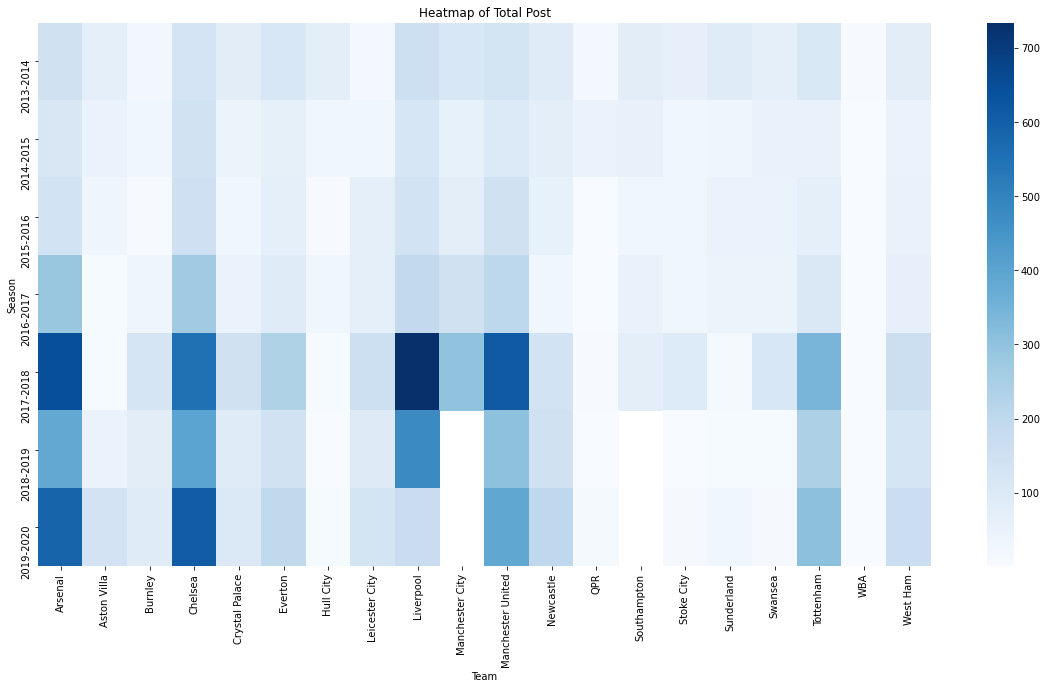

In [62]:
plt.figure(figsize = (20,10))
ax = sns.heatmap(post,cmap='Blues')
plt.title('Heatmap of Total Post')
plt.show() 

In [63]:
comments = epl.pivot('Season', 'Team', 'Total Comments')

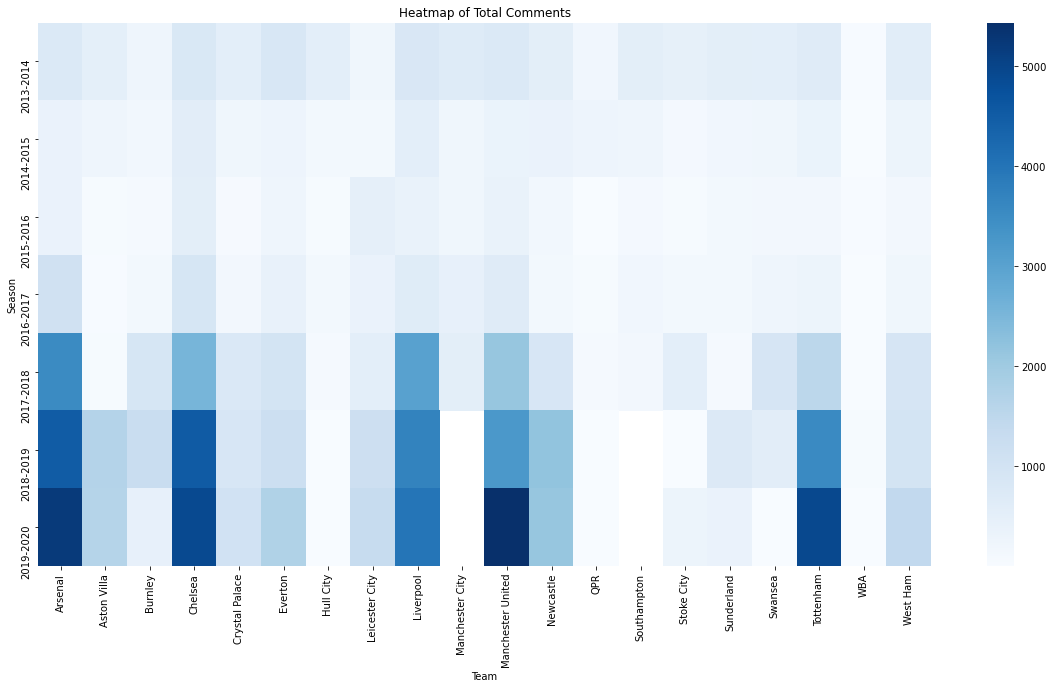

In [64]:
plt.figure(figsize = (20,10))
ax = sns.heatmap(comments,cmap='Blues')
plt.title('Heatmap of Total Comments')
plt.show() 

In [65]:
score = epl.pivot('Season', 'Team', 'Score')
score

Team,Arsenal,Aston Villa,Burnley,Chelsea,Crystal Palace,Everton,Hull City,Leicester City,Liverpool,Manchester City,Manchester United,Newcastle,QPR,Southampton,Stoke City,Sunderland,Swansea,Tottenham,WBA,West Ham
Season,,,,,,,,,,,,,,,,,,,,
2013-2014,474.0,282.0,121.0,506.0,354.0,455.0,267.0,62.0,483.0,324.0,312.0,297.0,66.0,286.0,247.0,331.0,255.0,368.0,3.0,265.0
2014-2015,217.0,175.0,79.0,327.0,156.0,193.0,45.0,166.0,266.0,178.0,225.0,164.0,110.0,111.0,66.0,81.0,189.0,138.0,5.0,201.0
2015-2016,291.0,21.0,26.0,301.0,55.0,94.0,17.0,94.0,230.0,78.0,124.0,165.0,0.0,53.0,85.0,40.0,86.0,120.0,19.0,94.0
2016-2017,423.0,11.0,104.0,440.0,102.0,215.0,27.0,129.0,316.0,141.0,250.0,111.0,17.0,89.0,82.0,62.0,182.0,146.0,1.0,148.0
2017-2018,1027.0,43.0,297.0,783.0,288.0,366.0,41.0,176.0,1069.0,124.0,653.0,356.0,47.0,24.0,246.0,51.0,458.0,838.0,0.0,232.0
2018-2019,2375.0,599.0,562.0,2355.0,470.0,870.0,7.0,749.0,3004.0,NaN,1440.0,1050.0,22.0,NaN,25.0,45.0,138.0,1563.0,47.0,745.0
2019-2020,5995.0,2081.0,612.0,6638.0,1113.0,2580.0,139.0,2045.0,1513.0,NaN,3905.0,2512.0,172.0,NaN,186.0,634.0,253.0,3729.0,1.0,1604.0


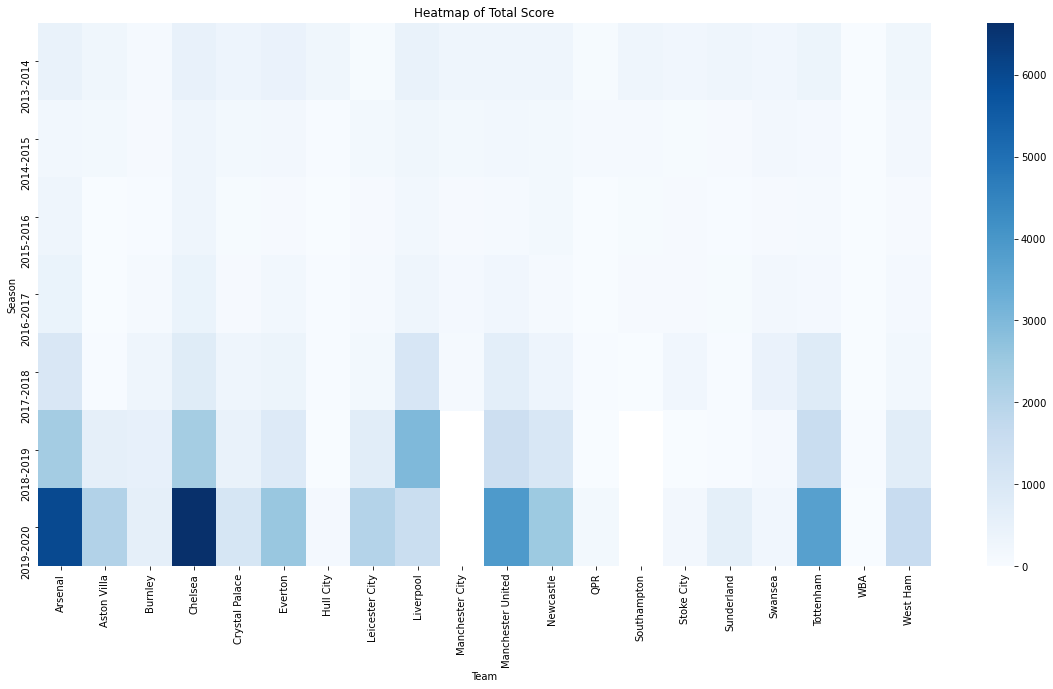

In [67]:
plt.figure(figsize = (20,10))
ax = sns.heatmap(score, cmap='Blues')
plt.title('Heatmap of Total Score')
plt.show() 